# Project initialization

## Importing libraries

In [335]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
#import warnings
#warnings.filterwarnings("ignore")

## Importing and cleaning the dataset

In [344]:
# coffee beans in a certain coffe store
df = pd.read_csv("data/coffeebeans.csv", parse_dates=["Harvest.Year"])

# change column names '.' to '_'
df.columns = df.columns.str.replace('.', '_')

# change feet to meter (all altitudes are already converted to meter, the unit was not corrected)
df["unit_of_measurement"] = 'm'

# fix wrong altitude values
df.iloc[543, 41:44] = 1100.0
df.iloc[896, 41:44] = 1901.64
df.iloc[1144, 41:44] = 1901.64
df.iloc[1040, 41:44] = 1100.0

# convert harvest year to dates (some dates are in weird format, these will be lost during conversion)
df["Harvest_Year"] = pd.to_datetime(df["Harvest_Year"], errors="coerce")

# use grading dates for missing harvest years as these are pretty close to the harvest year
df["Harvest_Year"].fillna(df["Grading_Date"], inplace=True)

# only keep Year from the timestamp
df["Harvest_Year"] = df["Harvest_Year"].dt.strftime("%Y")

# replace country names
countries = ["Tanzania, United Republic Of", "United States (Hawaii)", "United States (Puerto Rico)", "Cote d?Ivoire"]
countries_new = ["Tanzania", "Hawaii", "Puerto Rico", "Cote d'Ivoire"]

for c, cn in zip(countries, countries_new):
    df = df.replace(to_replace=c, value=cn)
    
# drop values with missing tcp rating
df = df[df["Total_Cup_Points"] > 0]


## Number of coffee bean types per country

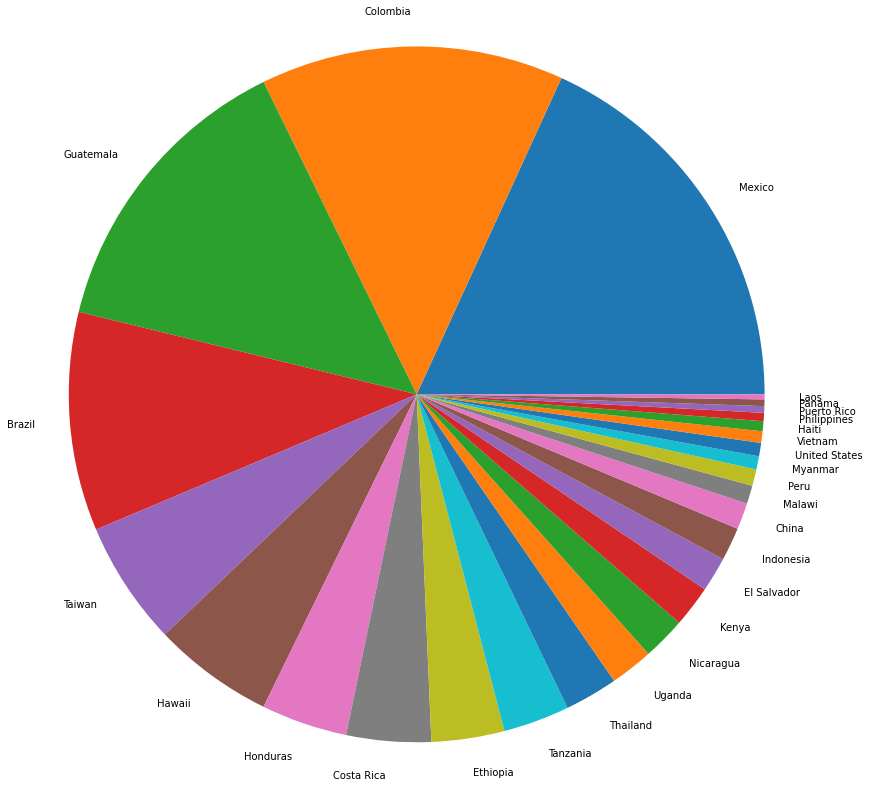

In [251]:
coffee_per_country = df.groupby(["Country_of_Origin"]).count()

# only show countries that have more than one coffee bean type
coffee_per_country = coffee_per_country[~(coffee_per_country["Species"] <= 2)]
coffee_per_country_sorted = coffee_per_country.sort_values(by="Species", ascending=False)

plt.figure(figsize=(8,8))
plt.pie(coffee_per_country_sorted["Species"], radius=2, labels=coffee_per_country_sorted.index)
plt.show()

## Number of coffee bean types per harvest year

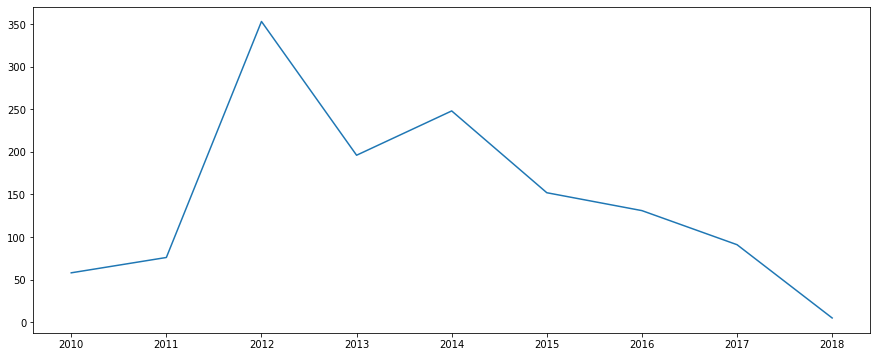

In [252]:
ctype_per_year = df.groupby(["Harvest_Year"])["Species"].count()
plt.figure(figsize=(15,6))
plt.plot(ctype_per_year.index, ctype_per_year.values)
plt.show()

## Average rating of coffee beans by year

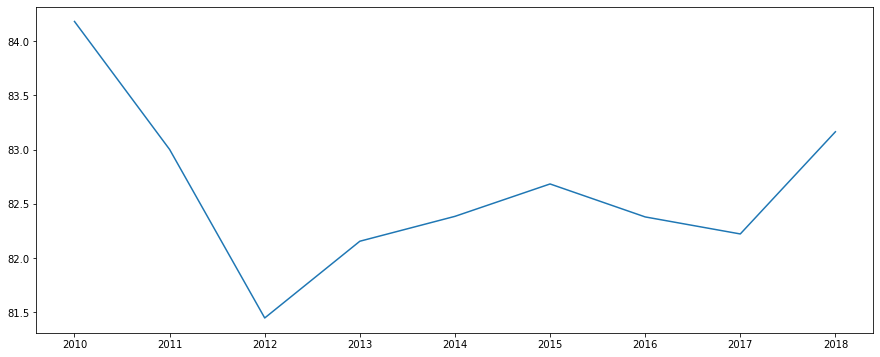

In [67]:
rating_per_year = df.groupby(["Harvest_Year"]).mean()

plt.figure(figsize=(15,6))
plt.plot(rating_per_year.index, rating_per_year["Total_Cup_Points"])
plt.show()

## Average rating of coffee beans by year on interpolated spline chart

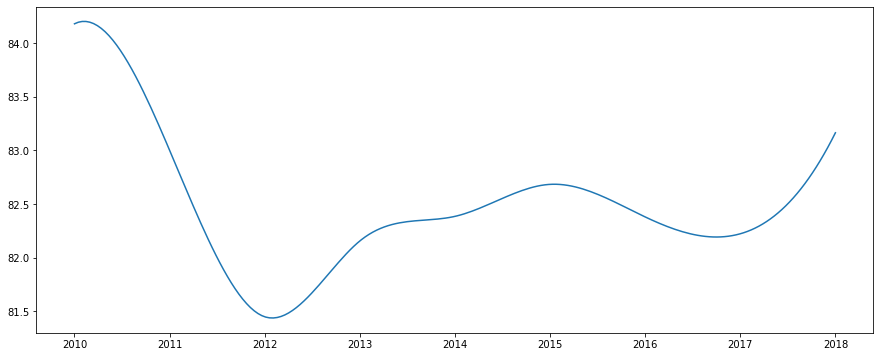

In [45]:
rating_per_year = df.groupby(["Harvest_Year"]).mean()

x = np.array(rating_per_year.index)
y = np.array(rating_per_year["Total_Cup_Points"])

#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(float(x.min()), float(x.max()), 200) 

#define spline
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(xnew)

#create smooth line chart 
plt.figure(figsize=(15,6))
plt.plot(xnew, y_smooth)
plt.show()

## Average rating of coffee beans by year per country

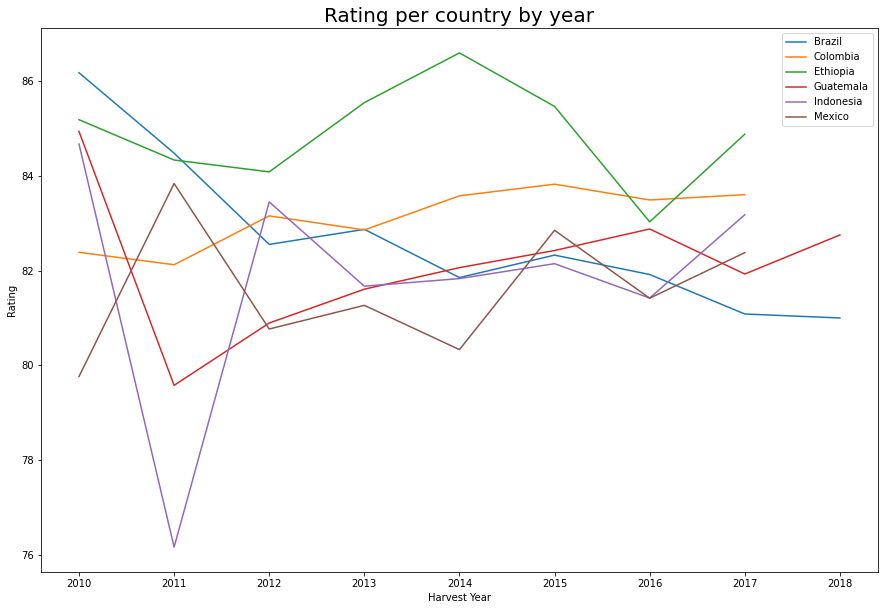

In [347]:
rating_per_year_country = df.groupby(["Harvest_Year", "Country_of_Origin"])["Total_Cup_Points"].mean().unstack()

# only create plot for countries with at least 8 ratings
rating_per_year_country = rating_per_year_country.loc[:,rating_per_year_country.notna().sum(0) >= 8]

# line plot setup
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(rating_per_year_country.index, rating_per_year_country.values)

# set labels/title
ax.set_xlabel("Harvest Year")
ax.set_ylabel("Rating")
ax.set_title(("Rating per country by year"), fontsize=20)
ax.legend(rating_per_year_country.columns,loc="best")

plt.show()

## Average rating of coffee beans per country

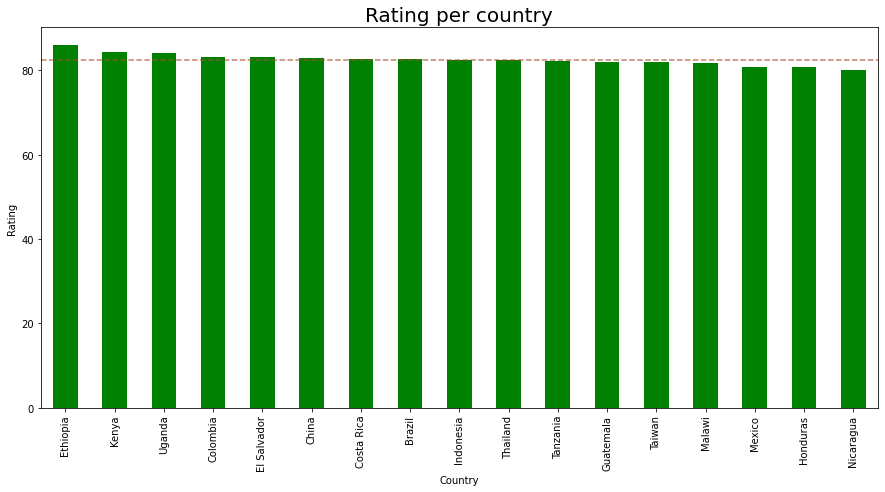

In [334]:
rating_per_country = df.groupby("Country_of_Origin").agg(count=("Country_of_Origin", "size"), mean=("Total_Cup_Points", "mean")).reset_index()
rating_per_country = rating_per_country[rating_per_country["count"] >= 10]
rating_per_country = rating_per_country.sort_values(by="mean", ascending=False)
rating_per_country.set_index(rating_per_country["Country_of_Origin"], inplace=True)
rating_per_country.drop(columns=['count'], inplace=True)

# bar plot setup
fig,ax = plt.subplots()
rating_per_country.plot(kind="bar", ax=ax, color="green", figsize=(15,7))

# set labels/title
ax.set_xlabel("Country")
ax.set_ylabel("Rating")
ax.set_title(("Rating per country"), fontsize=20)

# use axhline
mean = rating_per_country["mean"].mean()
ax.axhline(mean, alpha=0.7, linestyle="--", color="sienna")

# remove legend
legend = ax.legend().remove()

plt.show()

## Coffee bean producing regions' elevations per country

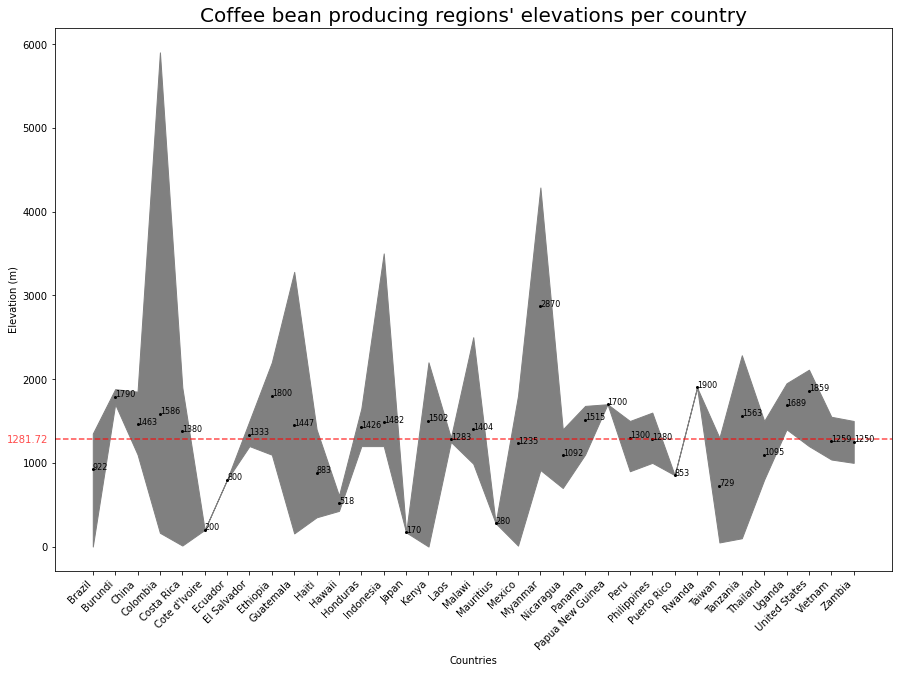

In [336]:
# drop rows that have no altitude data
df = df.dropna(subset=["altitude_mean_meters"])

# get lowest and highest elevation of coffee producing region per country
country_minimum_alt = df.groupby(["Country_of_Origin"])["altitude_low_meters"].min()
country_maximum_alt = df.groupby(["Country_of_Origin"])["altitude_high_meters"].max()

# get the average for each country by averaging their regional averages
country_mean_alt = df.groupby(["Country_of_Origin"])["altitude_mean_meters"].mean()

# average elevation for coffee bean producing
avg_alt = df["altitude_mean_meters"].mean()

# fillbetween, scatter plots setup
fig,ax = plt.subplots(figsize=(15,10))

ax.fill_between(country_minimum_alt.index, country_minimum_alt.values, country_maximum_alt.values, color="gray")
ax.scatter(country_mean_alt.index, country_mean_alt.values, color="black", s=4)

# set labels, title
ax.set_xlabel("Countries")
ax.set_ylabel("Elevation (m)")
ax.set_title(("Coffee bean producing regions' elevations per country"), fontsize=20)
ax.set_xticklabels(country_minimum_alt.index, rotation=45, ha='right')

# add horizontal line for average
mean = country_mean_alt.values.mean()
ax.axhline(mean, alpha=0.7, linestyle="--", color="red")
ax.text(-2.9, mean, round(mean, 2), fontsize=10, va="center", ha="center", backgroundcolor="w", color="red", alpha=0.7)

# show values of each country's average elevation point of farms
for cma_ind, cma_val in list(zip(country_mean_alt.index, country_mean_alt.values)):
    ax.annotate(round(cma_val),xy=(cma_ind, cma_val+0.1), fontsize=8, color="black")

plt.show()

## Average rating of coffee beans per elevation

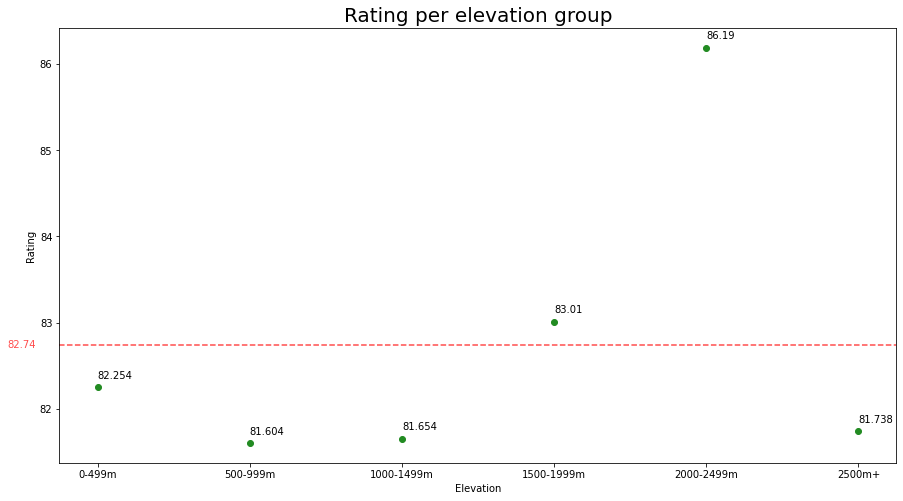

In [292]:
elevation_list = ["0-499m", "500-999m", "1000-1499m", "1500-1999m", "2000-2499m", "2500m+"]

def check_elevation(x):
    if x < 500:
       return elevation_list[0]
    elif 500 <= x < 1000:
       return elevation_list[1]
    elif 1000 <= x < 1500:
       return elevation_list[2]
    elif 1500 <= x < 2000:
       return elevation_list[3]
    elif 2000 <= x < 2500:
       return elevation_list[4]
    else:
       return elevation_list[5]

df["elevation_group"] = df["altitude_mean_meters"].apply(check_elevation)
rating_per_elevation = df.groupby(["elevation_group"])["Total_Cup_Points"].mean()
rating_per_elevation = rating_per_elevation.reindex(elevation_list)

rpe_df = pd.DataFrame(rating_per_elevation)

# scatter plot setup
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(rpe_df.index, rpe_df["Total_Cup_Points"], color="forestgreen")

ax.set_xlabel("Elevation")
ax.set_ylabel("Rating")
ax.set_title(("Rating per elevation group"), fontsize=20)

# add horizontal line for average
mean = rpe_df["Total_Cup_Points"].mean()
ax.axhline(mean, alpha=0.7, linestyle="--", color="red")
ax.text(-0.5, mean, round(mean, 2), fontsize=10, va="center", ha="center", backgroundcolor="w", color="red", alpha=0.7)

# show values of each point
for rpe_ind, rpe_rat in list(zip(rpe_df.index, rpe_df["Total_Cup_Points"])):
    ax.annotate(round(rpe_rat, 3),xy=(rpe_ind, rpe_rat+0.1))


plt.show()